# Introduction
Machine learning competitions are a great way to improve your data science skills and measure your progress. 

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to improve and see how you stack up to others taking this course.

The link to the competition is https://www.kaggle.com/c/home-data-for-ml-course/overview

A tutorial on this competition I am following: https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process

In [148]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

iowa_file_path = 'train.csv'

home_data = pd.read_csv(iowa_file_path, index_col=0)

# Understanding the Data

In [149]:
home_data.select_dtypes(exclude="object").describe().round(decimals=2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0
mean,56.9,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.2
std,42.3,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.5
min,20.0,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0
25%,20.0,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0
50%,50.0,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0
75%,70.0,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0
max,190.0,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.0


In [150]:
home_data.select_dtypes(include="object").describe().round(decimals=2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


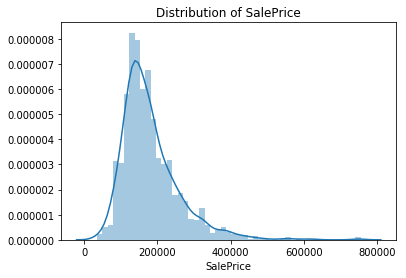

In [151]:
target = home_data.SalePrice
plt.figure()
sns.distplot(target)
plt.title("Distribution of SalePrice")
plt.show()

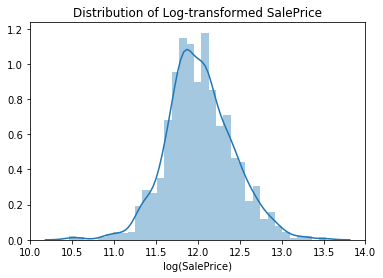

In [152]:
sns.distplot(np.log(target))
plt.title("Distribution of Log-transformed SalePrice")
plt.xlabel("log(SalePrice)")
plt.show()

# Partial Dependence Plots

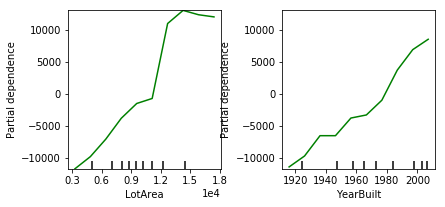

In [153]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

gb_model = GradientBoostingRegressor()
gb_model.fit(X_imputed,y)
my_plots = plot_partial_dependence(gb_model, features=[0,1], X=X_imputed,
                                   feature_names=['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 
                                                  'TotalBsmtSF', 'GarageCars', 'OverallCond', 'OverallQual', 
                                                  'Neighborhood', 'CentralAir'], grid_resolution=10)

In [154]:
y = home_data.SalePrice
updated_features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'TotalBsmtSF', 'GarageCars', 'OverallCond',
                    'OverallQual', 'KitchenQual', 'Neighborhood', 'CentralAir', 'LowQualFinSF', 'Condition2']
X = pd.get_dummies(home_data[updated_features])
X_imputed = SimpleImputer().fit_transform(X)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Compare Different Models with Train Test Split

In [155]:
iowa_model = DecisionTreeRegressor(random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

iowa_model = DecisionTreeRegressor(max_leaf_nodes=100, random_state=1)
iowa_model.fit(train_X, train_y)
val_predictions = iowa_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE for best value of max_leaf_nodes: {:,.0f}".format(val_mae))

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)
print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

gb_model = GradientBoostingRegressor(random_state=1)
gb_model.fit(train_X, train_y)
gb_val_predictions = gb_model.predict(val_X)
gb_val_mae = mean_absolute_error(gb_val_predictions, val_y)
print("Validation MAE for Gradient Boosting: {:,.0f}".format(gb_val_mae))

Validation MAE when not specifying max_leaf_nodes: 26,506
Validation MAE for best value of max_leaf_nodes: 25,356
Validation MAE for Random Forest Model: 19,132
Validation MAE for Gradient Boosting: 16,979


# Pipeline And Cross Validation

In [156]:
xg_pipeline = make_pipeline(SimpleImputer(), XGBRegressor(n_estimators=300, learning_rate=0.1))
xg_pipeline.fit(train_X, train_y)
xg_predictions = xg_pipeline.predict(val_X)
xg_val_mae = mean_absolute_error(xg_predictions, val_y)
print("MAE for XGBoost with Train Test Tplit: {:,.0f}".format(xg_val_mae))

MAE_scores = cross_val_score(xg_pipeline, X, y, scoring='neg_mean_absolute_error')
print('MAE for XGBoost with Cross Validation %2f' %(-1 * MAE_scores.mean()))

MSE_scores = cross_val_score(xg_pipeline, X, y, scoring='neg_mean_squared_error')
print('RMSE for XGBoost with Cross Validation %2f' %(np.sqrt(-1 * MSE_scores)).mean())

MAE for XGBoost with Train Test Tplit: 16,317
MAE for XGBoost with Cross Validation 16986.696898
RMSE for XGBoost with Cross Validation 27428.851195


# Align Training and Test Sets

In [157]:
test_data_path = 'test.csv'
test_data = pd.read_csv(test_data_path)

one_hot_encoded_test = pd.get_dummies(test_data[updated_features])
final_train, final_test = X.align(one_hot_encoded_test, join='inner', axis=1)

# Make Predictions

In [158]:
xg_on_full_data = XGBRegressor(n_estimators=300, learning_rate=0.1)
xg_on_full_data.fit(final_train, y)
test_preds = xg_on_full_data.predict(final_test)

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)